<a href="https://colab.research.google.com/github/lxlyp438/PyTorch_Deep_Learning_course/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##01. PyTorch Workflow Fundamentals - 2025.12.05

data -> build model -> training -> prediction/inference and evaluate the model -> saving and loading the model -> putting it all together

**Algo**:

*Gradient descent* https://www.youtube.com/watch?v=IHZwWFHWa-w

*Backpropagation* https://www.youtube.com/watch?v=Ilg3gGewQ5U

In [ ]:
# PyTorch Workflow
import torch
from torch import nn # nn contains all PyTorch's building blocks for neural network
import matplotlib.pyplot as plt

torch.__version__

'2.9.0+cu126'

## 1. Data (Preparing and Loading)

data: Excel sheet, images, videos, audios, DNA, texts

Convert data into a numerical representation -> build a model to learn patterns

In [ ]:
# Creating data using linear regression formula
# create known parameters
weight = 0.7
bias = 0.3

# create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10], len(X), len(y)

### Spliting data into training, validation and testing sets

In [ ]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
# visualize the data
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")

  plt.legend(prop={"size": 14});

In [ ]:
plot_predictions()

In [ ]:
# PyTorch linear regression model

class LinearRegressionModel(nn.Module): # inherits nn.Module
  def __init__(self):
    super().__init__()

    # initialize model perameters
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
  # forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- 'x' is the input data
      return self.weights * x + self.bias;

### PyTorch model building essentials

* **torch.nn** - building blocks for computational graphs
* **torch.nn.Parameters** - the parameters the model try and learn, often a PyTorch layer from torch.nn will set these for us
* **torch.nn.Module** - base module/class
* **torch.optim** - the optimizer of PyTorch, help with Gradient Descent
* **def forward()** - All nn.Module subclasses must override this method

*PyTorch Cheat Sheet*: https://www.learnpytorch.io/pytorch_cheatsheet/

In [ ]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

print(list(model_0.parameters()))

print(model_0.state_dict()) # model_0.weights, model_0.bias

# making predictions/inference
'''
inference mode stops all the processess (e.g., tracking the gradient) that are
not needed during inference/prediction, making it faster,
can also use `with torch.no_grad():`
PyTorch inference mode twitter
'''
with torch.inference_mode():  # context manager
  y_preds=model_0(X_test)

y_preds

plot_predictions(predictions=y_preds)


### Train model (Loss function, Cost function, Criterion)

* **Loss function**,
* **Optimizer**

PyTorch loss function and optimizer in `torch.nn`, `torch.optim`

* Training loop
* Testing loop

### **Question**: why the cost fluctuates between 2 values?


In [ ]:
# loss function
loss_fn = nn.L1Loss()

# optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # learning rate - hyperparameter

# Training loop
'''
0. loop through the data and do the following ...
1. forward pass (data moving through the model's `forward()` - forward propogation)
2. Calculate the loss
3. OPtimizer zero grad
4. Loss backward - move backwards throught the model/network to calculate the gradients
of each of the parameters of the model with respect to the loss (backpropagation)
5. Optimizer step - use the optimizer to adjust the model's parameters to try
and improve/reduce the loss (gradient descent)
'''

epochs = 200
prev_train_loss = -1

# Track different values
epoch_count = []
training_loss_values = []
test_loss_values = []

for epoch in range(epochs):
#while True:
  # Set the model to training mode (the default mode as well)
  model_0.train() # track gradient where needed

  # 1. forward pass
  y_pred = model_0(X_train)

  # 2. calculate the loss
  loss = loss_fn(y_pred, y_train)

  '''
  if (prev_train_loss < 0) & (abs(prev_train_loss - loss) < 0.00001):
    print(f"Epoch count: {epoch_count}")
    break

  #print(f"prev loss: {prev_train_loss}, current loss: {loss}")
  prev_train_loss = loss
  '''

  #print(f"Loss: {loss}")

  # 3. optimizer zero grad - zero the optimizer gradients
  optimizer.zero_grad()

  # 4. perform backpropagation on the loss w.r.t. the parameters of the model
  loss.backward()

  # 5. Step the optimizer (gradient descent)
  '''
  by default, the optimizer changes will accumulate through the loop, so we have
  to zero them in step 3 for next iteration
  '''
  optimizer.step()

  ### Testing

  model_0.eval() # turn off settings not needed for evaluation/testing (dropout/batch norm layers)
  with torch.inference_mode(): # turn off gradient tracking and couple of other things
  # with `torch.no_grad() in older code
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)


  #if epoch % 10 == 0:
  epoch_count.append(epoch)
  training_loss_values.append(loss)
  test_loss_values.append(test_loss)
  print(f"Epoch: {epoch} | Training Loss: {loss} | Test loss: {test_loss}")

  '''
  #epoch_count = epoch_count + 1
  epoch_count.append(epoch)
  training_loss_values.append(loss)
  test_loss_values.append(test_loss)

  if epoch_count > 1000:
    break
  '''
  #print(model_0.state_dict())

In [ ]:
import numpy as np
#print(training_loss_values)
#temp = training_loss_values.numpy()

#epoch_count_arr = np.arange(1, epoch_count+1)
plt.plot(epoch_count, torch.tensor(training_loss_values).numpy(), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

with torch.inference_mode():
  y_preds = model_0(X_test)
plot_predictions(predictions=y_preds)
model_0.state_dict()


### Saving and loading a model in PyTorch

1. `torch.save()` - save a PyTorch object in Python's pickle format
2. `torch.load()` - load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` -  load a model's saved state dictionary

**PyTorch save and load models** tutorial

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# Saving the PyTorch model
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

MODEL_SAVE_PATH

#3. Save model state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
!ls -l models

total 4
-rw-r--r-- 1 root root 2117 Dec  9 20:11 01_pytorch_workflow_model_0.pth


In [ ]:
## Loading a PyTorch model

# To load in a saved state_dict, have to instantiate a new instance of the model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_0.state_dict()

# Make inference from the loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

## Putting it all together

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

# create device-agnostic code.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

#!nvidia-smi

Using device: cpu


model_1 state: OrderedDict({'linear_layer.weight': tensor([[-0.2996]]), 'linear_layer.bias': tensor([0.6485])})
False
model_1 device: cpu
OrderedDict({'linear_layer.weight': tensor([[0.6944]]), 'linear_layer.bias': tensor([0.3045])})
y_preds.device: cpu
Test Loss: [tensor(0.0139), tensor(0.0005), tensor(0.0139), tensor(0.0005), tensor(0.0139), tensor(0.0005), tensor(0.0139), tensor(0.0005), tensor(0.0139), tensor(0.0005)]
Train Loss: [0.00234282 0.00917817 0.00234282 0.00917817 0.00234282 0.00917817
 0.00234282 0.00917817 0.00234282 0.00917817]
loaded model_1: OrderedDict({'linear_layer.weight': tensor([[0.6944]]), 'linear_layer.bias': tensor([0.3045])})


/tmp/ipython-input-3211788057.py:126: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  plt.plot(epoch_count, torch.tensor(train_loss_values).numpy(), label="Train Loss")


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

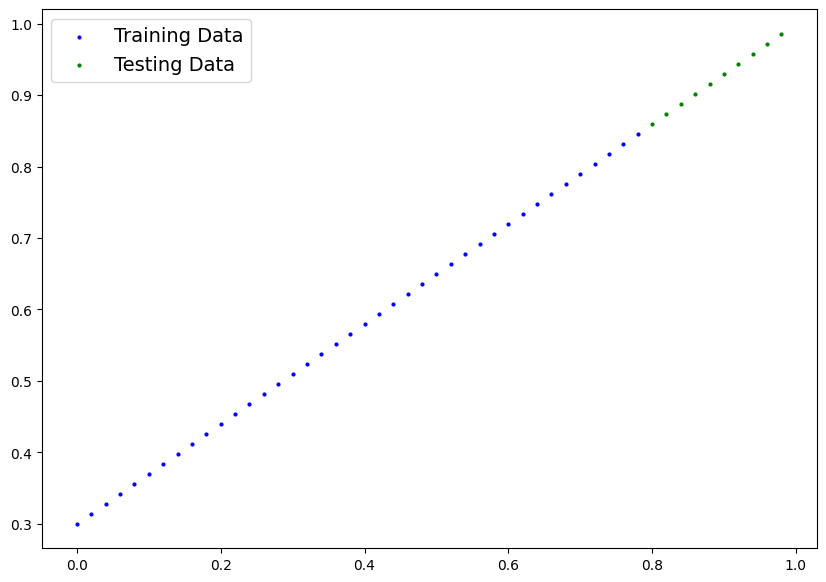

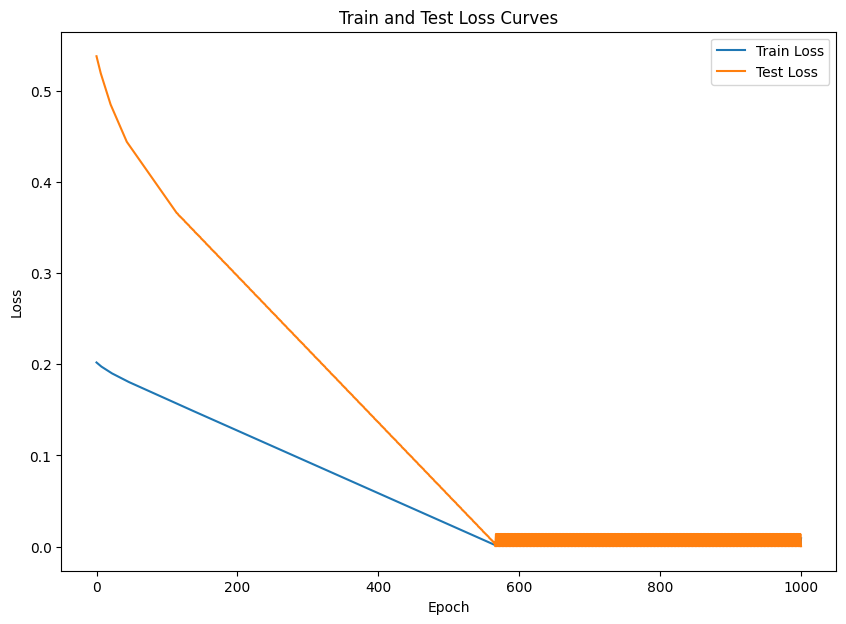

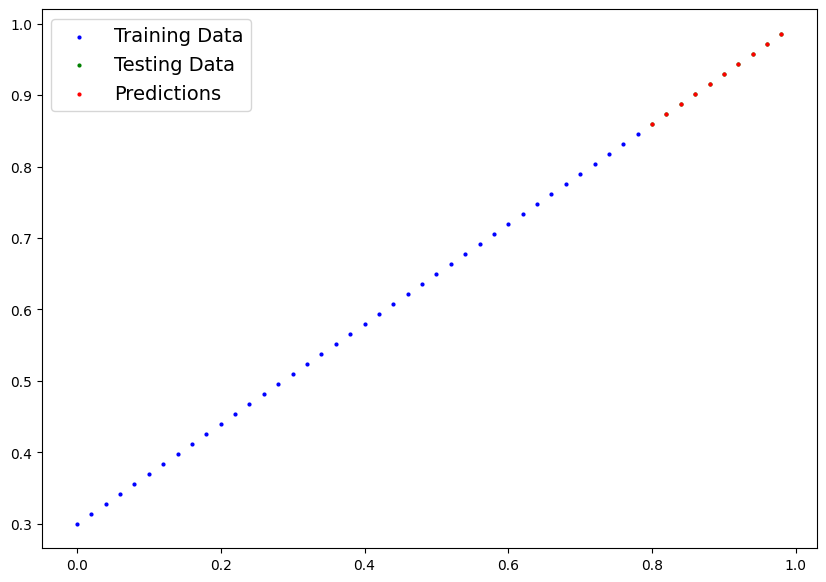

In [2]:
# create some data y = weight * X + bias
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

# create X and y (features, labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # unsqueeze is needed for shapes within linear year
y = weight * X + bias
X[:10], y[:10]
X.shape, y.shape
#torch.arange(start, end, step).unsqueeze(dim=1).shape

# split data
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(X_test)

# Put data on the target device (device agnostic code for data)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Plot the data
# plot function
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10,7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing Data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")

  plt.legend(prop={"size":14})

plot_predictions(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu())

# Define the model - using PyTorch linear regression model
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    '''
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
    '''
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x:torch.Tensor)-> torch.Tensor:
    #return self.weights * x + self.bias
    return self.linear_layer(x)

#torch.manual_seed(42)

# Instantiate a model object
model_1 = LinearRegressionModelV2()
print(f"model_1 state: {model_1.state_dict()}")
print(next(model_1.parameters()).is_cuda)
model_1.to(device)
#print(next(model_1.parameters()).is_cuda)
print(f"model_1 device: {next(model_1.parameters()).device}")

# Train the model
loss_fcn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

# Training loop
epoch = 0
prev_test_loss = torch.finfo(torch.float32).max
epochs = 2000
epoch_count = []
train_loss_values = []
test_loss_values = []

#for epoch in range(epochs):
while (True):
  model_1.train()
  y_pred = model_1(X_train)
  train_loss = loss_fcn(y_pred, y_train)

  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fcn(test_pred, y_test)

  #if (len(test_loss_values) > 180):
  #  print(f"Train Loss: {train_loss}, Test Loss: {test_loss}")
  epoch_count.append(epoch)
  train_loss_values.append(train_loss)
  test_loss_values.append(test_loss)


  if (abs(prev_test_loss - test_loss) < 0.00001):
    print(f"Test Loss is small enough, prev_test_loss: {prev_test_loss}, test_loss: {test_loss}")
    break
  else:
    prev_test_loss = test_loss

  if (len(test_loss_values) > 1000):
    break


# Plot
#import numpy as np

epoch_count = torch.arange(0, len(test_loss_values))
plt.figure(figsize=(10, 7))
plt.plot(epoch_count, torch.tensor(train_loss_values).numpy(), label="Train Loss")
plt.plot(epoch_count, torch.tensor(test_loss_values).numpy(), label="Test Loss")
plt.title("Train and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

# Making predictions/inference
print(model_1.state_dict())
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds
#print(f"Is y_preds cuda?: {y_preds.is_cuda}")
print(f"y_preds.device: {y_preds.device}")

plot_predictions(X_train.cpu(),
                 y_train.cpu(),
                 X_test.cpu(),
                 y_test.cpu(),
                 y_preds.cpu())

print(f"Test Loss: {test_loss_values[(len(test_loss_values)-10):]}")
print(f"Train Loss: {torch.tensor(train_loss_values).numpy()[(len(test_loss_values)-10):]}")

# Saving and loading model
import pathlib
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_ptytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

# Loading
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model_1.to(device)
print(f"loaded model_1: {loaded_model_1.state_dict()}")

loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds
